In [1]:
# so basic idea, use the sampler to generate potenital points to explore
# then eval cig_mod at those points
# that is what an mcmc is LOL

In [37]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as scp

In [38]:
import numpy as np
from scipy import interpolate
from scipy import stats
import healpy as hp  # NOTE: you can neglect warning about version mismatch in CFITSIO if necessary 

N_side = 2048      # Both maps will have this N_side. Healpix map has 12 * N_side**2 pixels

from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy import units as u

import pandas as pd

import emcee

import matplotlib.pyplot as plt
import os, sys, shutil
import random
import sklearn.metrics as slm

import corner
from scipy.interpolate import interp1d
%matplotlib inline

pkdir = "/pscratch/sd/s/sbrisin/boss_cib_cmass/cibcmass/hmvec"
sys.path.insert(0, pkdir)
# Import hmvec as hm
from hmvec import hmvec as hm

In [39]:
# initalize model etc etc
# we want our values for each, arbiratily lets explore between Log_m(eff) of 10 to 20 and L_0 of 1e-7 to 9e-7 
# just for shits and gigs
# p0,x the x is the burn in which gives it space to explore the parameter space a lil bit 

In [62]:
def theory(theta):
    x, y = theta
    '''
    x is Log M_eff
    y is L0
    this function takes in theta and returns an array of the C_ls for galaxy and the CIB
    at the center of the given redshift bins
    the number of elements must match the number of elements in the data
    this function is a big big big function but takes in, l range, theta, number of bins
    and returns the c_l gg, cl gi, cov, cov inverse, yea
    
    gdndz, and zs come from the eBOSS galaxy catelogue
    requires: hcos, hmvec
    be sure to run this per each redshift bin
    this is specific the version to run for the mcmc <3
    '''

    ells = np.array([370,510,650,790,930])
    cib_freq = 545 * 1e9


    zs = np.linspace(.4, .5, 10) # make this variable
    ms = np.geomspace(1e10, 1e17, 20) # revisit the webb sky, 
    #lower mass limit and see if the disagreement goes away 
    ks = np.geomspace(1e-4, 100, 100)

    hcos = hm.HaloModel(zs, ks, ms=ms)
    hcos.set_cibParams('vierro')

        # a and b are the z range
    hcos.cib_params['alpha'] = 0.2
    hcos.cib_params['beta'] = 1.6
    hcos.cib_params['gamma'] = 1.7  # not in Viero, so using Planck13
    hcos.cib_params['delta'] = 2.4
    hcos.cib_params['Td_o'] = 20.7
    hcos.cib_params['logM_eff'] = x
    hcos.cib_params['var'] = 0.3
    hcos.cib_params['L_o'] = y
    hcos.add_hod(name="CMASS", mthresh=10**12 + zs*0.)
        
    # this is for the c_gg, make these inputs
    gdndz = np.array([3091.0, 4697.0,7307.0,11655.0,18705.0,25476.0,	31238.0,37006.0	,40371.0,	43370.0])
    zs = np.array([0.40000978,0.41000876,0.42000774,0.4300067,0.4400057,0.45000467,0.46000364,0.47000262,0.4800016,0.49000058])

    '''Pgg_1h = hcos.get_power_1halo('CMASS', 'CMASS', nu_obs=np.array([cib_freq]))
    Pgg_2h = hcos.get_power_2halo('CMASS', 'CMASS', nu_obs=np.array([cib_freq]))

    Cl_gg_1h = hcos.C_gg(ells, hcos.zs, hcos.ks, Pgg_1h, gzs=zs, gdndz=gdndz)
    Cl_gg_2h = hcos.C_gg(ells, hcos.zs, hcos.ks, Pgg_2h, gzs=zs, gdndz=gdndz)
    tot_gg = Cl_gg_1h + Cl_gg_2h # add the halos together '''
    # for the cl gi
    PgI_1h = hcos.get_power_1halo('CMASS', 'cib', nu_obs=np.array([cib_freq]))
    PgI_2h = hcos.get_power_2halo('CMASS', 'cib', nu_obs=np.array([cib_freq]))

    Cl_gI_1h = hcos.C_gI(ells, hcos.zs, hcos.ks, PgI_1h, gzs=zs, gdndz= gdndz)
    Cl_gI_2h = hcos.C_gI(ells, hcos.zs, hcos.ks, PgI_2h, gzs=zs, gdndz= gdndz)
    
    # need to end up with one vector thats c_gi for each l bin, c_gg for each l bin
    tot_gi = Cl_gI_1h + Cl_gI_2h
    print(tot_gi)
    #370.0,510.0,650.0,790.0, 930.0        
    return np.array(tot_gi)

NameError: name 'dat' is not defined

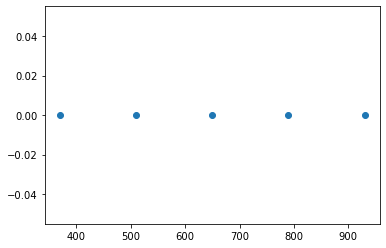

In [5]:
plt.scatter([370,510,650,790,930], theory([-3.843e+02,-1.441e-34]))

plt.scatter([370,510,650,790,930], dat)



In [41]:
binnedvar = np.array([1.89627266e-15, 8.77247382e-16, 3.96679922e-16, 2.41161963e-16,
       1.54683514e-16]) # this is from a different no|tebook but till i can get it nice AAA

In [42]:
dat = np.array([1.506013e-08, 1.593685e-08,1.071126e-08, 1.097310e-08, 5.175340e-09]) # this is the data
cov = np.diag(binnedvar)

# this is your covariance matrix
cinv = np.linalg.inv(cov) # inverse covariance matrix

In [73]:
def model(theta, dat = dat):
    x,y =  theta 
    return theory(theta)
def lnprior(theta):
    x,y =  theta 
    return 0.0
def lnlike(theta,cinv,cov,dat = dat):
    thy = theory(theta) # this works dimensionally
    diff = thy-dat #model - data 
    return -0.5* np.dot(diff,np.dot(cinv,diff))#/np.sqrt(np.linalg.det(2*np.pi*cov))
def lnprob(theta):
    x,y = theta
    lp = lnlike(theta,cinv,cov)
    if lp == np.inf:
        return np.inf
    elif lp == -np.inf:
        return -np.inf
    elif abs(lp) < 100:
        return lp + lnprior(theta)
    else:
        return print('AAAAAA')

In [85]:
x = np.linspace(2e-8,2e-5,2)
y= np.linspace(1e30,1e32,2)
ells = np.array([370,510,650,790,930])

[6.17927869e-13 4.56479191e-13 3.83638528e-13 3.42202966e-13
 3.15199935e-13]
[6.17927869e-11 4.56479191e-11 3.83638528e-11 3.42202966e-11
 3.15199935e-11]
[6.18257247e-13 4.56722499e-13 3.83843004e-13 3.42385353e-13
 3.15367927e-13]
[6.18257247e-11 4.56722499e-11 3.83843004e-11 3.42385353e-11
 3.15367927e-11]


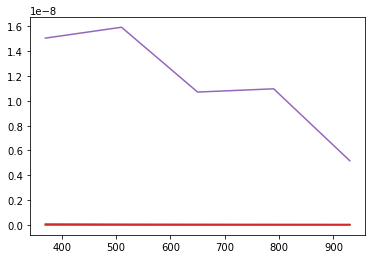

In [86]:
for i in x:
    for j in y:
        plt.plot(ells,theory([i,j]))
plt.plot(ells,dat)

In [46]:
lnprob([2e-7,1e35])

-5.406784954853995

In [49]:
scp.minimize(lnprob,[2e-7,1e35])

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -5.406784954853995
        x: [ 2.000e-07  1.000e+35]
      nit: 0
      jac: [-3.843e+02 -1.441e-34]
 hess_inv: [[1 0]
            [0 1]]
     nfev: 92
     njev: 29

In [60]:
theory([2e-7,1e35])

array([6.17930836e-08, 4.56481383e-08, 3.83640370e-08, 3.42204609e-08,
       3.15201448e-08])

In [63]:
theory([-3.843e+02, -1.441e-34])

[0. 0. 0. 0. 0.]


array([0., 0., 0., 0., 0.])

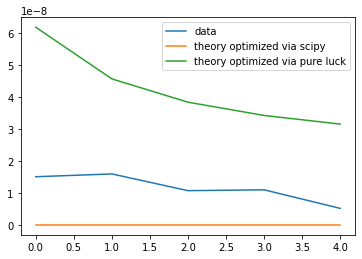

In [55]:
plt.plot(dat, label = 'data')
plt.plot(theory([-3.843e+02, -1.441e-34]), label = 'theory optimized via scipy')
plt.plot(theory([2e-7,1e35]), label = 'theory optimized via pure luck')
plt.legend()

In [56]:
plt.savefig('pltsept26.pdf')

<Figure size 432x288 with 0 Axes>

In [74]:
def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler =  emcee.EnsembleSampler(nwalkers,ndim, lnprob, args = data)
    print('running baybee..')
    p0, _, _,_= sampler.run_mcmc(p0,1)
    sampler.reset()
    
    print( 'running prod')
    pos, prob, state, _  =  sampler.run_mcmc(p0,niter)
    print('done!')
    return sampler, pos, prob, state

In [75]:
data = (dat,cov,cinv)
nwalkers = 4
niter = 10
# set n walkers
# set niter 
initial = np.array([-3.843e+02, -1.441e-34]) # these come from the initial vierro params
ndim = 2 # only 2 params so 2 dim
p0 = [np.array(initial) + np.random.randn(ndim) for i in range(nwalkers)]

In [76]:
sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnlike,data)
samples = sampler.flatchain

running baybee..
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
running prod
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
done!


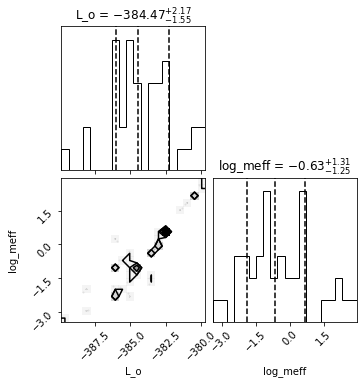

In [77]:
labels = ['L_o', 'log_meff']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

In [78]:
flat_samples = sampler.get_chain(discard=1, thin=1, flat=True)
print(flat_samples)

[[-3.86098652e+02 -8.96492730e-01]
 [-3.84699665e+02 -1.01159078e+00]
 [-3.86265611e+02 -2.31213801e+00]
 [-3.80117808e+02  2.60562276e+00]
 [-3.85005653e+02 -5.98431214e-01]
 [-3.84813420e+02 -1.10139679e+00]
 [-3.83666862e+02 -2.33342152e-01]
 [-3.79689021e+02  2.94861852e+00]
 [-3.85118065e+02 -3.04313413e-01]
 [-3.84750623e+02 -1.26570182e+00]
 [-3.82835198e+02  4.31923428e-01]
 [-3.81358941e+02  1.61281350e+00]
 [-3.85811092e+02 -6.69251243e-01]
 [-3.86033923e+02 -2.40308025e+00]
 [-3.83090942e+02  2.05260224e-01]
 [-3.81165314e+02  1.77714464e+00]
 [-3.85848045e+02 -9.56775613e-01]
 [-3.84943051e+02 -1.43624904e+00]
 [-3.82603919e+02  6.36905006e-01]
 [-3.80532312e+02  2.14671013e+00]
 [-3.88343397e+02 -2.11260014e+00]
 [-3.85241506e+02 -1.67869242e+00]
 [-3.82559052e+02  6.76670124e-01]
 [-3.82369097e+02  6.54641503e-01]
 [-3.86265614e+02 -1.82194959e+00]
 [-3.83720608e+02 -1.46594165e+00]
 [-3.82433965e+02  6.62164040e-01]
 [-3.82279231e+02  6.44219979e-01]
 [-3.88013788e+02 -2

-4535.5341702488795


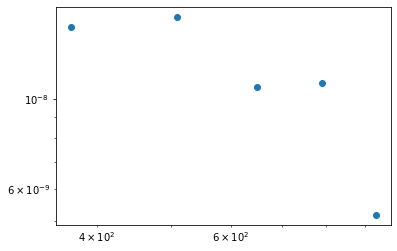

In [82]:
print(samples)
plt.scatter([370,510,650,790,930],dat)
plt.xscale('log')
plt.yscale('log')

In [ ]:
ah = pd.DataFrame(samples)
vals = ah[0]
np.mean(vals)

In [31]:
flat_samples = sampler.get_chain(discard=0, thin=15, flat=True)

In [39]:
from IPython.display import display, Math
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [87]:
    ells = np.arange(3000)
    cib_freq = 545 * 1e9


    zs = np.linspace(.4, .5, 10) # make this variable
    ms = np.geomspace(1e10, 1e17, 20) # revisit the webb sky, 
    #lower mass limit and see if the disagreement goes away 
    ks = np.geomspace(1e-4, 100, 100)

    hcos = hm.HaloModel(zs, ks, ms=ms)
    hcos.set_cibParams('vierro')

        # a and b are the z range
    hcos.cib_params['alpha'] = 0.2
    hcos.cib_params['beta'] = 1.6
    hcos.cib_params['gamma'] = 1.7  # not in Viero, so using Planck13
    hcos.cib_params['delta'] = 2.4
    hcos.cib_params['Td_o'] = 20.7
    hcos.cib_params['logM_eff'] = 10
    hcos.cib_params['var'] = 0.3
    hcos.cib_params['L_o'] = 3.098/1e14
    hcos.add_hod(name="CMASS", mthresh=10**10 + zs*0.)
    ells = np.arange(300,1000)
        
    # this is for the c_gg, make these inputs
    gdndz = 100 * np.array([3091.0, 4697.0,7307.0,11655.0,18705.0,25476.0,	31238.0,37006.0	,40371.0,	43370.0])
    zs = np.array([0.40000978,0.41000876,0.42000774,0.4300067,0.4400057,0.45000467,0.46000364,0.47000262,0.4800016,0.49000058])

    Pgg_1h = hcos.get_power_1halo('CMASS', 'CMASS', nu_obs=np.array([cib_freq]))
    Pgg_2h = hcos.get_power_2halo('CMASS', 'CMASS', nu_obs=np.array([cib_freq]))

    Cl_gg_1h = hcos.C_gg(ells, hcos.zs, hcos.ks, Pgg_1h, gzs=zs, gdndz=gdndz)
    Cl_gg_2h = hcos.C_gg(ells, hcos.zs, hcos.ks, Pgg_2h, gzs=zs, gdndz=gdndz)
    tot_gg = Cl_gg_1h + Cl_gg_2h # add the halos together
    PgI_1h = hcos.get_power_1halo('CMASS', 'cib', nu_obs=np.array([cib_freq]))
    PgI_2h = hcos.get_power_2halo('CMASS', 'cib', nu_obs=np.array([cib_freq]))

    Cl_gI_1h = hcos.C_gI(ells, hcos.zs, hcos.ks, PgI_1h, gzs=zs, gdndz= gdndz)
    Cl_gI_2h = hcos.C_gI(ells, hcos.zs, hcos.ks, PgI_2h, gzs=zs, gdndz= gdndz)
    
    # need to end up with one vector thats c_gi for each l bin, c_gg for each l bin
    tot_gi = Cl_gI_1h + Cl_gI_2h

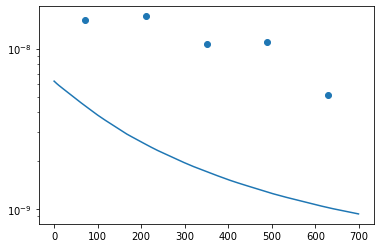

In [89]:
plt.plot(tot_gi)
b = np.array([70,210,350,490,630])
plt.scatter(b,dat)
plt.yscale('log')